In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, r2_score
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import GridSearchCV

In [2]:
annonimized = pd.read_csv("annonimized.csv") 
qt_public = pd.read_csv("qt-public.csv")  
qt_public

,hash,diemqt
0,00b6dd4fc7eb817e03708c532016ef30ce564a61,7.5
1,00bef8afee8f3c595d535c9c03c490cac1a4f021,7
2,01122b3ef7e59b84189e65985305f575d6bdf83c,9
3,013de369c439ab0ead8aa7da64423aa395a8be39,10
4,014c59c6433fd764a0b08de6ffeb757eaf60aa73,9
...,...,...
756,840d07858c03f80f4695056e2cc7d0c474b83a25,9
757,844f5db2e7e31ae51eba025480679ed7e4708ac6,8
758,845acd04a77b3d1b623f255d9f9f8eae90892dab,6.5
759,8460eaaf887a6289fb156f7562fb739ba8e9629e,10


In [3]:
column_mapping = {
    "concat('it001',`assignment_id`)": "assignment_id",
    "concat('it001',`problem_id`)": "problem_id",
    "concat('it001', username)": "username",
    "is_final": "is_final",
    "status": "status",
    "pre_score": "pre_score",
    "coefficient": "coefficient",
    "concat('it001',`language_id`)": "language_id",
    "created_at": "created_at",
    "updated_at": "updated_at",
    "judgement": "judgement"
}

column_mapping_th = {
    "hash": "username",
    "diemqt": "QT"
}

annonimized.rename(columns=column_mapping, inplace=True)

qt_public.rename(columns=column_mapping_th, inplace=True)

In [4]:
problem_count_per_assignment = annonimized.groupby('assignment_id')['problem_id'].count().reset_index()
problem_count_per_assignment.rename(columns={'problem_id': 'total_problem_count'}, inplace=True)

assignment_count_per_user = annonimized.groupby('username')['assignment_id'].count().reset_index()
assignment_count_per_user.rename(columns={'assignment_id': 'total_assignment_count'}, inplace=True)

annonimized = annonimized.merge(problem_count_per_assignment, on='assignment_id', how='left')
annonimized = annonimized.merge(assignment_count_per_user, on='username', how='left')

# annonimized = pd.get_dummies(annonimized, columns=['status'], prefix='status')
# annonimized = annonimized[annonimized["status"] == "SCORE"].reset_index(drop=True)

status_mapping = {
    'SCORE': 0,
    'Compilation Error': 1,
    'Syntax Error': 2,
    'pending': 3
}

if 'status' in annonimized.columns:
    annonimized['status_normalized'] = annonimized['status'].map(status_mapping)

In [5]:
annonimized

,assignment_id,problem_id,username,is_final,status,pre_score,coefficient,language_id,created_at,updated_at,judgement,total_problem_count,total_assignment_count,status_normalized
0,90ce27571176d87961b565d5ef4b3de33ede04ac,789454427dd4097a14749e3dde63346b7a8d3811,ed9eaeb6a707f50154024b24d7efcb874a9795dd,0,SCORE,0,100,it0012,10-09 08:02:04,10-09 08:06:58,"{""times"":[0,0,0,0,0,0,0,0,0,0],""mems"":[0,0,0,0...",2246,139,0
1,90ce27571176d87961b565d5ef4b3de33ede04ac,789454427dd4097a14749e3dde63346b7a8d3811,ed9eaeb6a707f50154024b24d7efcb874a9795dd,0,SCORE,0,100,it0012,10-09 08:04:41,10-09 08:04:51,"{""times"":[0,0,0,0,0,0,0,0,0,0],""mems"":[0,0,0,0...",2246,139,0
2,90ce27571176d87961b565d5ef4b3de33ede04ac,789454427dd4097a14749e3dde63346b7a8d3811,ed9eaeb6a707f50154024b24d7efcb874a9795dd,1,SCORE,10000,100,it0012,10-09 08:06:49,10-09 08:06:58,"{""times"":[0,0,0,0,0,0,0,0,0,0],""mems"":[0,0,0,0...",2246,139,0
3,90ce27571176d87961b565d5ef4b3de33ede04ac,bf96fbdc5f499538c3e2bfbec5779c8a14b0a9ff,ed9eaeb6a707f50154024b24d7efcb874a9795dd,1,SCORE,10000,100,it0012,10-09 08:47:52,10-09 08:48:01,"{""times"":[0,0,0,0,0,0,0,0,0,0],""mems"":[0,0,0,0...",2246,139,0
4,90ce27571176d87961b565d5ef4b3de33ede04ac,7a6e5ca470ff47c3b5048f240c4738de71010c78,ed9eaeb6a707f50154024b24d7efcb874a9795dd,1,SCORE,10000,100,it0012,10-09 09:19:35,10-09 09:19:45,"{""times"":[0,0,0,0,0,0,0,0,0,0],""mems"":[0,0,0,0...",2246,139,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
295193,613aea04c978f5e72fffc8bcff1f7b695a63f7b1,388516cbf597351226be1bdbe5ef30b9dcef570f,232cce96362898f08e9150ba244adaf2d6583ab2,1,SCORE,10000,100,it0012,01-15 16:03:43,01-15 16:03:53,"{""times"":[0,0,0,0,0,0,0,0,0,0,0,0,0,0],""mems"":...",2749,228,0
295194,613aea04c978f5e72fffc8bcff1f7b695a63f7b1,d2b96124ccb8e27b4b8dacdb935e729cb1ba546b,232cce96362898f08e9150ba244adaf2d6583ab2,0,Compilation Error,0,100,it0012,01-15 16:04:07,01-15 16:05:08,"{""times"":[],""mems"":[],""verdicts"":{""\n\nIn func...",2749,228,1
295195,613aea04c978f5e72fffc8bcff1f7b695a63f7b1,d2b96124ccb8e27b4b8dacdb935e729cb1ba546b,232cce96362898f08e9150ba244adaf2d6583ab2,1,SCORE,10000,100,it0012,01-15 16:04:58,01-15 16:05:08,"{""times"":[0,0,0,0,0,0,0,0,0,0,0,0,0,0],""mems"":...",2749,228,0
295196,613aea04c978f5e72fffc8bcff1f7b695a63f7b1,8c0f8dd4ff55e1609f733e043ac5e88b1dde6e7c,232cce96362898f08e9150ba244adaf2d6583ab2,1,SCORE,10000,100,it0012,01-15 16:05:13,01-15 16:05:22,"{""times"":[0,0,0,0,0,0,0,0,0,0,0,0,0],""mems"":[0...",2749,228,0


In [6]:
grouped_data = annonimized.groupby('username').agg({
    'assignment_id': lambda x: '|'.join(map(str, x.unique())),
    'problem_id': lambda x: '|'.join(map(str, x.unique())),
    'pre_score': 'mean',  
    'coefficient' : 'mean' , 
    'status_normalized' : 'sum',
    'judgement': lambda x: '|'.join(map(str, x.unique())), 
    'total_problem_count': 'first', 
    'total_assignment_count': 'first'  
}).reset_index()

In [7]:
grouped_data["judgement"][1]

'{"times":[],"mems":[],"verdicts":{"\\n\\nforbidden phrase: &quot;include&quot; is banned\\nforbidden phrase: &quot;using&quot; is banned\\nforbidden phrase: &quot;;&quot; is banned\\n":1}}|{"times":[],"mems":[],"verdicts":{"\\n\\nforbidden phrase: &quot;;&quot; is banned\\n":1}}|{"times":[0,0,0,0,0,0,0,0,0,0],"mems":[0,0,0,0,0,0,0,0,0,0],"verdicts":[]}|{"times":[0,0,0,0,0,0,0,0,0,0],"mems":[0,0,0,0,0,0,0,0,0,0],"verdicts":{"WRONG":10}}|{"times":[],"mems":[],"verdicts":{"\\n\\nforbidden phrase: &quot;using&quot; is banned\\n":1}}|{"times":[],"mems":[],"verdicts":{"\\n\\nIn function \'int main()\':\\n6:33: error: \'endl\' was not declared in this scope; did you mean \'std::endl\'?\\n":1}}|{"times":[],"mems":[],"verdicts":{"\\n\\nIn function \'int main()\':\\n7:14: error: statement cannot resolve address of overloaded function\\n":1}}|{"times":[],"mems":[],"verdicts":{"\\n\\nIn function \'int main()\':\\n6:28: error: \'setpresion\' was not declared in this scope\\n6:43: error: \'fixed\' 

In [8]:
grouped_data = grouped_data.merge(qt_public[['username', 'QT']], on='username', how='left')

In [9]:
from sklearn.preprocessing import StandardScaler, LabelEncoder

def encode_column(col):
    return col.apply(lambda x: len(set(x.split('|')))) 

grouped_data.loc[:, 'assignment_id'] = encode_column(grouped_data['assignment_id'])
grouped_data.loc[:, 'problem_id'] = encode_column(grouped_data['problem_id'])
grouped_data.loc[:, 'judgement'] = encode_column(grouped_data['judgement'])

In [10]:
grouped_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1489 entries, 0 to 1488
Data columns (total 10 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   username                1489 non-null   object 
 1   assignment_id           1489 non-null   object 
 2   problem_id              1489 non-null   object 
 3   pre_score               1489 non-null   float64
 4   coefficient             1489 non-null   float64
 5   status_normalized       1489 non-null   int64  
 6   judgement               1489 non-null   object 
 7   total_problem_count     1489 non-null   int64  
 8   total_assignment_count  1489 non-null   int64  
 9   QT                      755 non-null    object 
dtypes: float64(2), int64(3), object(5)
memory usage: 116.5+ KB


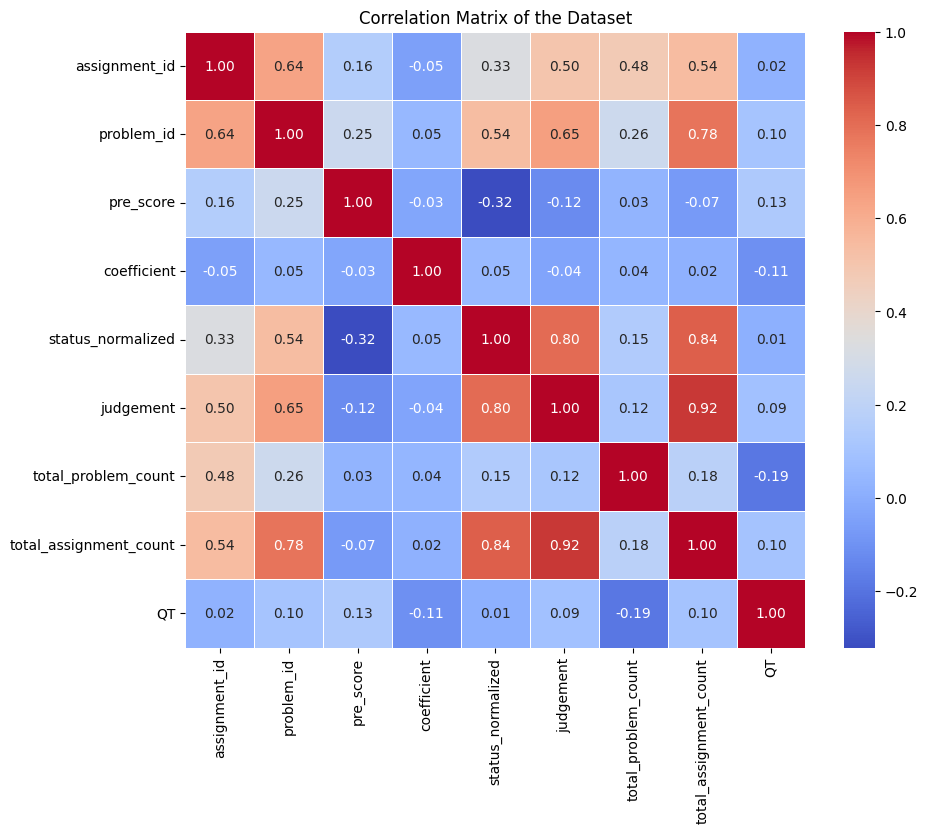

In [11]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.cluster import KMeans

#grouped_data['problem_judgement_interaction'] = grouped_data['total_problem_count'] * grouped_data['judgement']

train_data_new = grouped_data.copy()

train_data_new['QT'] = pd.to_numeric(train_data_new['QT'], errors='coerce')

correlation_matrix = train_data_new.drop(columns="username").corr()

plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)
plt.title('Correlation Matrix of the Dataset')
plt.show()

In [12]:
grouped_data.columns

Index(['username', 'assignment_id', 'problem_id', 'pre_score', 'coefficient',
       'status_normalized', 'judgement', 'total_problem_count',
       'total_assignment_count', 'QT'],
      dtype='object')

In [13]:
train_data = grouped_data.dropna(subset=['QT']).copy()
features = ['assignment_id', 'problem_id', 'pre_score', 'judgement', 'total_assignment_count','total_problem_count']

X = train_data[features]
y = train_data['QT']

print(y.unique())
y = y.replace({'\xa0': 0, '': 0}, regex=True)
y = y.astype(float)

print(y.unique())

['7.5' '7' '9' '10' '8' '9.5' '6.5' '8.5' '6' '4.5' '5' '1.5' '5.5' '0'
 '1' '2.5' '2' '3.5' '4' '\xa0' '3']
[ 7.5  7.   9.  10.   8.   9.5  6.5  8.5  6.   4.5  5.   1.5  5.5  0.
  1.   2.5  2.   3.5  4.   3. ]


In [14]:
y.shape

(755,)

In [15]:
X

,assignment_id,problem_id,pre_score,judgement,total_assignment_count,total_problem_count
0,7,46,5504.149660,72,147,321
1,9,78,5488.552124,107,259,2049
2,7,66,5973.753846,95,195,212
4,8,52,6474.448598,38,107,2057
5,9,90,5240.025126,70,199,2233
...,...,...,...,...,...,...
796,6,43,5171.639640,50,111,370
797,17,104,4785.224090,125,357,7114
798,8,52,4247.296774,61,155,7114
799,12,114,4278.605027,224,557,938


In [16]:
from sklearn.ensemble import GradientBoostingRegressor
from catboost import CatBoostRegressor
from sklearn.model_selection import train_test_split, KFold

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42)

model = RandomForestRegressor(
    n_estimators=300,          
    max_depth=20,              
    min_samples_split=5,       
    min_samples_leaf=4,        
    max_features='sqrt',       
    bootstrap=True,            
    random_state=42            
)

model.fit(X_train, y_train)

RandomForestRegressor(max_depth=20, max_features='sqrt', min_samples_leaf=4,
                      min_samples_split=5, n_estimators=300, random_state=42)

In [17]:
y_pred = model.predict(X_test)

mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
mse = ((y_test - y_pred) ** 2).mean()

print(f"Đánh giá hiệu năng mô hình:")
print(f"Mean Absolute Error (MAE): {mae:.4f}")
print(f"R-squared (R²): {r2:.4f}")
print(f"Mean Squared Error (MSE): {mse:.4f}")

Đánh giá hiệu năng mô hình:
Mean Absolute Error (MAE): 1.1223
R-squared (R²): 0.4332
Mean Squared Error (MSE): 2.4436


In [18]:
from sklearn.ensemble import GradientBoostingRegressor
from catboost import CatBoostRegressor
from sklearn.model_selection import train_test_split, KFold

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42)

model = GradientBoostingRegressor()

model.fit(X_train, y_train)

GradientBoostingRegressor()

In [19]:
y_pred = model.predict(X_test)

mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
mse = ((y_test - y_pred) ** 2).mean()

print(f"Đánh giá hiệu năng mô hình:")
print(f"Mean Absolute Error (MAE): {mae:.4f}")
print(f"R-squared (R²): {r2:.4f}")
print(f"Mean Squared Error (MSE): {mse:.4f}")

Đánh giá hiệu năng mô hình:
Mean Absolute Error (MAE): 0.9544
R-squared (R²): 0.5804
Mean Squared Error (MSE): 1.8091


- Mô hình GradientBoostingRegressor có R2 = 60% tốt hơn so với RandomForestRegressor có R2 = 43%. Tuy nhiên khi nộp kết quả thì mô hình RandomForestRegressor có kết quả tốt hơn.

In [20]:
from sklearn.ensemble import GradientBoostingRegressor
from catboost import CatBoostRegressor
from sklearn.model_selection import train_test_split, KFold

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42)
model = RandomForestRegressor(
    n_estimators=300,          
    max_depth=20,              
    min_samples_split=5,       
    min_samples_leaf=4,       
    max_features='sqrt',       
    bootstrap=True,            
    random_state=42            
)
model.fit(X, y)

RandomForestRegressor(max_depth=20, max_features='sqrt', min_samples_leaf=4,
                      min_samples_split=5, n_estimators=300, random_state=42)

In [21]:
# from sklearn.ensemble import GradientBoostingRegressor
# from catboost import CatBoostRegressor
# from sklearn.model_selection import train_test_split, KFold
# import pandas as pd
# import numpy as np
# from sklearn.model_selection import train_test_split, GridSearchCV
# from sklearn.linear_model import LinearRegression, Ridge, Lasso
# from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
# from sklearn.tree import DecisionTreeRegressor
# from sklearn.metrics import r2_score, mean_squared_error
# from sklearn.preprocessing import StandardScaler, LabelEncoder
# from sklearn.pipeline import Pipeline
# import tensorflow as tf
# from tensorflow.keras.models import Sequential
# from tensorflow.keras.layers import Dense, Dropout, Embedding, Flatten
# from tensorflow.keras.optimizers import Adam
# import datetime

# # Bước 6: Huấn luyện mô hình RandomForest
# # model = RandomForestRegressor()
# model = GradientBoostingRegressor()
# # model = CatBoostRegressor(verbose=0)

# model.fit(X, y)

# from tensorflow.keras.regularizers import l2
# from tensorflow.keras.layers import Dense, Dropout, BatchNormalization, LeakyReLU
# from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

# # Xây dựng mô hình mạng học sâu
# model = Sequential()

# # Layer 1
# model.add(Dense(256, input_dim=X_train.shape[1], kernel_regularizer=l2(0.001)))
# model.add(BatchNormalization())
# model.add(LeakyReLU())
# model.add(Dropout(0.3))

# # Layer 2
# model.add(Dense(128, kernel_regularizer=l2(0.001)))
# model.add(BatchNormalization())
# model.add(LeakyReLU())
# model.add(Dropout(0.3))

# # Layer 3
# model.add(Dense(64, kernel_regularizer=l2(0.001)))
# model.add(BatchNormalization())
# model.add(LeakyReLU())
# model.add(Dropout(0.2))

# # Output Layer
# model.add(Dense(1))

# # Biên dịch mô hình
# optimizer = Adam(learning_rate=0.001)
# model.compile(optimizer=optimizer, loss='mse')

# # Early Stopping và Giảm LR nếu không cải thiện
# callbacks = [
#     EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True),
#     ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=1e-5)
# ]

# # Huấn luyện mô hình
# history = model.fit(
#     X, y,
#     epochs=200,
#     batch_size=32,
#     validation_data=(X_test, y_test),
#     callbacks=callbacks,
#     verbose=0
# )

# # Dự đoán trên tập kiểm tra
# y_pred = model.predict(X)

# # Tính R^2
# r2 = r2_score(y, y_pred)
# print(f'R^2: {r2}')


In [22]:
data_to_predict = grouped_data[grouped_data['QT'].isna()]

X_to_predict = data_to_predict[features]
data_to_predict.loc[:, 'QT'] = model.predict(X_to_predict)

In [23]:
output = data_to_predict[['username', 'QT']]

output['QT'] = output['QT'].astype(float).round(2)

output

C:\Users\Admin\AppData\Local\Temp\ipykernel_6792\3513372176.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  output['QT'] = output['QT'].astype(float).round(2)


,username,QT
3,0134f9f410c65ad0e8c2254a7e9288670e02a183,8.69
20,035f97702f2c01d26ab1fae8f39ea2f98a0caa3c,8.92
40,06024da8147b5cf6105beb4c403f67cf1ff0aea1,9.19
68,0aaebc88f6106684d6993c156104c1ef36cf94e0,8.56
80,0bf111a9caedf02804f6991792490e63bc21058a,9.12
...,...,...
1484,feb8a2859a011c59efd22ed419cb69288fe03627,8.69
1485,fef4a3263ed9a8ab14d457694bb8fd86ccd98312,9.22
1486,ff12d6e2ab80696ed8e22fbe5497e96c68d29076,7.89
1487,ff3fa2ec64294f37ae968159f810ebeda7966c51,5.89


In [24]:
output.to_csv("predicted_QT_for_new_users.csv", index=False, header=False)

print("Kết quả dự đoán đã được lưu vào predicted_th_for_new_users.csv")

Kết quả dự đoán đã được lưu vào predicted_th_for_new_users.csv
